In [1]:
import pandas as pd
import matplotlib
import numpy as np
from  matplotlib import pyplot as plt
import datetime as dt 
import seaborn as sns
import itertools
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
from patsy import dmatrices
from collections import Counter

学习证券投资学与财务报表分析后初步感觉股票价格的变化很大程度上取决于公司的财务/非财务信息，单独研究股票价格波动曲线没有什么意义，或许所谓的使用数学模型预测股票价格走势只是无稽之谈。后来听邬瑜骏老师将的技术分析，很多炒股者会分析股票波动曲线并做出反应，那么他们的行为也会反映到股票价格的变动当中，因此利用历史价格波动来做预测似乎也有一定的道理。只是技术分析中那么多的指标与模型，又如何投入到股价预测中使用呢？

## 数据读取与预处理

In [2]:
# 读取数据，Date为时间索引
gold_df = pd.read_csv("./GOLD.csv",index_col='Date')
bitcoin_df = pd.read_csv('./BCHAIN-MKPRU.csv',index_col='Date')
gold_df.index = pd.to_datetime(gold_df.index)
bitcoin_df.index = pd.to_datetime(bitcoin_df.index)
gold_df = gold_df.sort_index()
gold_df


USD (PM)  change_days
Date                             
2016-09-12   1327.50          0.0
2016-09-13   1328.50          1.0
2016-09-14   1323.20          1.0
2016-09-15   1320.10          2.0
2016-09-16   1314.25          3.0
...              ...          ...
2021-09-06   1823.85          1.0
2021-09-07   1810.75          1.0
2021-09-08   1797.95          2.0
2021-09-09   1795.35          3.0
2021-09-10   1799.90          1.0

[1265 rows x 2 columns]

## 绘制价格走势折线图

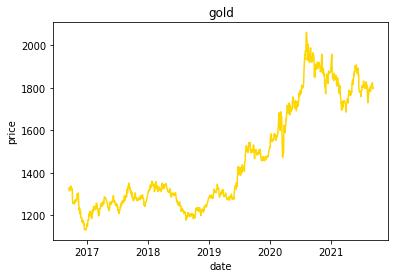

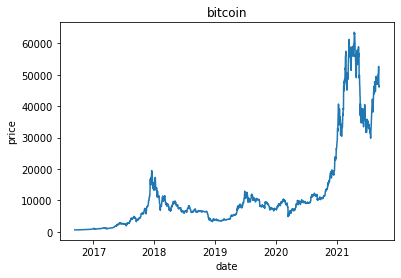

In [3]:

plt.figure()
#数据及线属性
plt.plot(gold_df.index, gold_df['USD (PM)'],'gold')
#标题设置
plt.title('gold')
plt.xlabel('date')
plt.ylabel('price')
plt.savefig('./gold_price.eps',format='eps',dpi=150)

plt.figure()
#数据及线属性
plt.plot(bitcoin_df.index, bitcoin_df['Value'])
#标题设置
plt.title('bitcoin')
plt.xlabel('date')
plt.ylabel('price')
plt.savefig('./bitcoin_price.eps',format='eps',dpi=150)

## 绘制一阶差分图

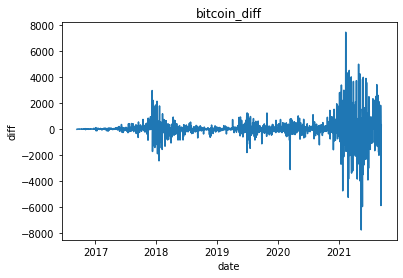

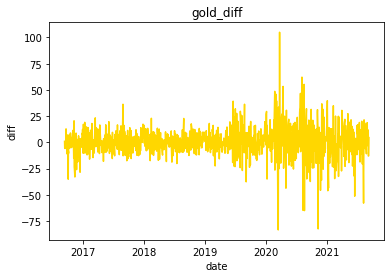

In [4]:
# 新增列为一阶差分
# bitcoin_df['diff'] = bitcoin_df['Value'].diff(1)

plt.figure()
#数据及线属性
plt.plot(bitcoin_df.index, bitcoin_df['Value'].diff(1))
#标题设置
plt.title('bitcoin_diff')
plt.xlabel('date')
plt.ylabel('diff')
plt.savefig('./bitcoin_diff.png.eps',format='eps',dpi=150)


# 新增列为一阶差分
# gold_df['diff'] = gold_df['USD (PM)'].diff(1)

plt.figure()
#数据及线属性
plt.plot(gold_df.index, gold_df['USD (PM)'].diff(1),'gold')
#标题设置
plt.title('gold_diff')
plt.xlabel('date')
plt.ylabel('diff')
plt.savefig('./gold_diff.eps',format='eps',dpi=150)

# out_fig = plt.gcf()
# out_fig.savefig('out.eps', format='eps', dpi=1000)

## 时间序列ARIMA(p,d,q)模型学习
### 1.模型介绍
该模型要求样本具有平稳性
        1. 平稳性：要求由样本时间序列所得的拟合曲线在未来一段时间内仍按照现有i形态的“惯性”延续下去。（均值方差无明显变化）
            ·严平稳：分布不随时间改变而变化
            ·弱平稳：期望与相关系数（依赖性）不变。未来时刻值与过去信息相关
        2. 差分法：时间序列在t与t-1时刻的差值
            ·一阶差分：在原始数据上使用pandas.diff函数求前后相邻差
            ·二阶差分：在一阶差分的数据上做差分
        3. 自回归模型(AR)
            描述当前值与历史值之间的关系，用变量的历史时间数据对自身进行预测
            p阶表示当前天与前p天数据有关
        4. 移动平均模型（MA）
            关注AR模型中误差项的累加，消除预测中的随机波动
### 2.参数设置
        1. 自相关函数ACF
        2. 偏自相关函数PACF： 剔除其他随机变量的影响
        ARIMA建模流程：
            1.将序列平稳：差分法确定d
            2.p和q阶数的确定：acf与pacf
            3.ARIMA(p,d,q)


## bitcoin预测

In [5]:
# 散点图也可以表示
import seaborn as sns
lags=9

df = bitcoin_df
ncols=3
nrows=int(np.ceil(lags/ncols))
 
fig, axes = plt.subplots(ncols=ncols, nrows=nrows, figsize=(4*ncols, 4*nrows))
 
for ax, lag in zip(axes.flat, np.arange(1,lags+1, 1)):
    lag_str = 't-{}'.format(lag)
    X = (pd.concat([df, df.shift(-lag)], axis=1,
                   keys=['y'] + [lag_str]).dropna())
 
    X.plot(ax=ax, kind='scatter', y='y', x=lag_str);
    corr = X.corr().values[0][1]
    ax.set_ylabel('Original')
    ax.set_title('Lag: {} (corr={:.2f})'.format(lag_str, corr));
    ax.set_aspect('equal');
    sns.despine();
 
fig.tight_layout();

C:\Users\27703\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\27703\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\27703\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\27703\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\27703\AppData\Local\Programs\Python\Python310\lib\s

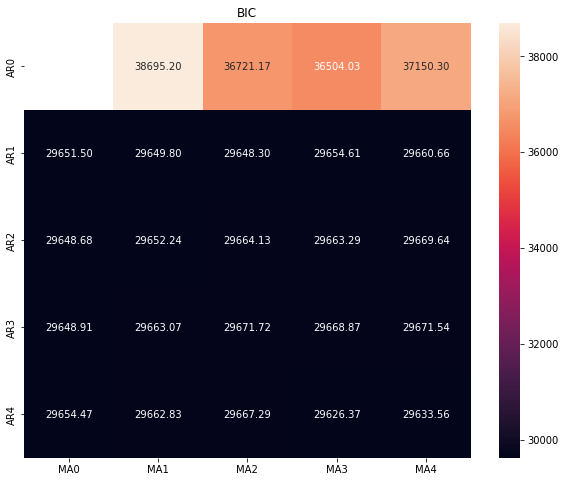

In [6]:
import itertools
ts_train =bitcoin_df
#当多组值都不符合时，遍历多组值，得出最好的值
p_min = 0
d_min = 0
q_min = 0
p_max = 4
d_max = 0
q_max = 4
 
# Initialize a DataFrame to store the results
results_bic = pd.DataFrame(index=['AR{}'.format(i) for i in range(p_min,p_max+1)],
                           columns=['MA{}'.format(i) for i in range(q_min,q_max+1)])
 
for p,d,q in itertools.product(range(p_min,p_max+1),
                               range(d_min,d_max+1),
                               range(q_min,q_max+1)):
    if p==0 and d==0 and q==0:
        results_bic.loc['AR{}'.format(p), 'MA{}'.format(q)] = np.nan
        continue
     
    try:
        model = sm.tsa.SARIMAX(ts_train, order=(p, d, q),
                               #enforce_stationarity=False,
                               #enforce_invertibility=False,
                              )
        results = model.fit()
        results_bic.loc['AR{}'.format(p), 'MA{}'.format(q)] = results.bic
    except:
        continue
results_bic = results_bic[results_bic.columns].astype(float)

fig, ax = plt.subplots(figsize=(10, 8))
ax = sns.heatmap(results_bic,
                 mask=results_bic.isnull(),
                 ax=ax,
                 annot=True,
                 fmt='.2f',
                 );
ax.set_title('BIC');
plt.savefig('./BIC_bitcoin.eps',format='eps',dpi=150)

In [7]:
# 查看AIC与BIC结果是否一致
train_results = sm.tsa.arma_order_select_ic(ts_train, ic=['aic', 'bic'], trend='n', max_ar=4, max_ma=4)
 
print('AIC', train_results.aic_min_order)
print('BIC', train_results.bic_min_order)

C:\Users\27703\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\27703\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\27703\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\27703\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn

AIC (4, 3)
BIC (4, 3)


In [8]:


# all = Counter(all) + Counter(pred_all_bitcoin)
# all = {}
# for k,v in pred_all_bitcoin.items():
#     all[k] = v
# # print(all)


pred_df = pd.DataFrame.from_dict(pred_all_bitcoin,orient='index',columns=['pred_value'])
print(pred_df)
# pred_df.to_csv(f'F:/{str(pred_df.index[0])[:10]}to{str(pred_df.index[-1])[:10]}.csv',index='True')


NameError: name 'pred_all_bitcoin' is not defined

### 预测函数

In [ ]:
# 根据历史预测明日价格的函数

def pred_by_history(df):
    model = ARIMA(df[:-1], order=(4, 1, 3))
    result = model.fit()
    # future = result.predict(df.index[-1]+dt.timedelta(1), df.index[-1] + dt.timedelta(3) ,dynamic=True, typ='levels')  #预测未来x天的股价
    future = result.forecast(1)          #预测的today价格
    return future

# today = pd.to_datetime('2016-09-13')
# get = pred_by_history(bitcoin_df[:today])

pred_all_bitcoin = {}        #存放所有预测值
for today in bitcoin_df['2016-09-14':].index.to_list():
    pred_res_bitcoin = pred_by_history(bitcoin_df[:today])          # 返回today的预测值
    pred_all_bitcoin[today] = pred_res_bitcoin[0]
    print(today)

# plt.figure(figsize=(6, 6))
# plt.xticks(rotation=45)
# plt.plot(pred_by_history(bitcoin_df[:today]))
# plt.plot(bitcoin_df[:today+ dt.timedelta(10)])

C:\Users\27703\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\27703\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\27703\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\27703\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to est

2016-09-14 00:00:00
2016-09-15 00:00:00
2016-09-16 00:00:00


C:\Users\27703\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\27703\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\27703\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\27703\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to est

2016-09-17 00:00:00


C:\Users\27703\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\27703\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\27703\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\27703\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\27703\AppData\Local\Programs\Py

2016-09-18 00:00:00


C:\Users\27703\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\27703\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\27703\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\27703\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\27703\AppData\Local\Programs\Py

2016-09-19 00:00:00


C:\Users\27703\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\27703\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\27703\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\27703\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\27703\AppData\Local\Programs\Py

2016-09-20 00:00:00


C:\Users\27703\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\27703\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\27703\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\27703\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\27703\AppData\Local\Programs\Py

2016-09-21 00:00:00


C:\Users\27703\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


2016-09-22 00:00:00


C:\Users\27703\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\27703\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\27703\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\27703\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:902: RuntimeWarning: Mean of empty slice.
  params_variance = (residuals[k_params_ma:] ** 2).mean()
C:\Users\27703\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\

LinAlgError: Schur decomposition solver error.

## gold预测

C:\Users\27703\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


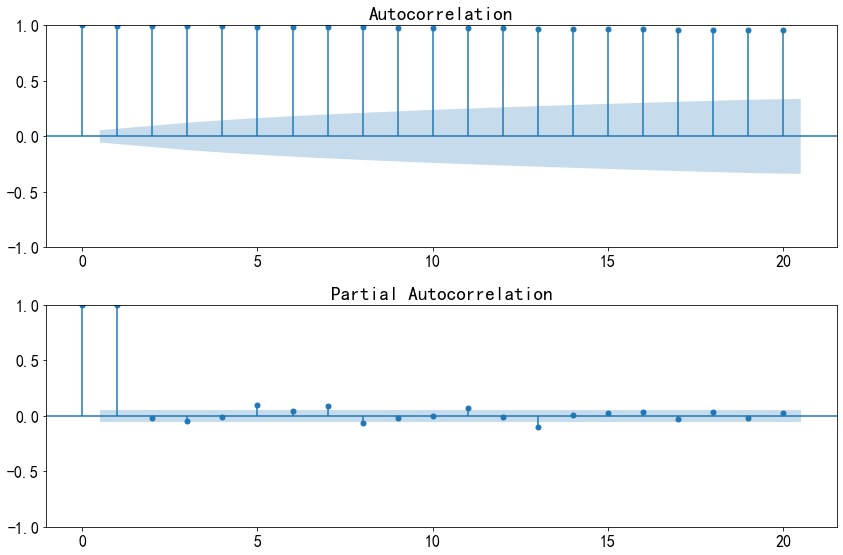

In [133]:
# 通过acf与pacf选p,q
df = gold_df.dropna()

fig = plt.figure(figsize=(12,8))
#acf
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df, lags=20,ax=ax1)
ax1.xaxis.set_ticks_position('bottom')
fig.tight_layout();
#pacf
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df, lags=20, ax=ax2)
ax2.xaxis.set_ticks_position('bottom')
fig.tight_layout();
#下图中的阴影表示置信区间，可以看出不同阶数自相关性的变化情况，从而选出p值和q值

C:\Users\27703\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


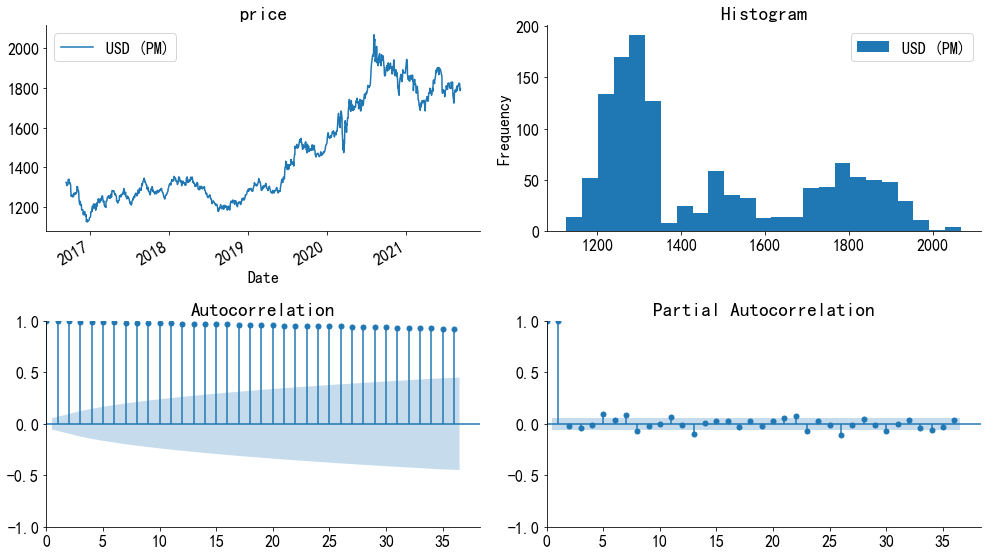

In [134]:
# 更直观用以下四个图进行评估和分析
def tsplot(y, lags=None, title='', figsize=(14, 8)):
    
    fig = plt.figure(figsize=figsize)
    layout = (2, 2)
    ts_ax   = plt.subplot2grid(layout, (0, 0))
    hist_ax = plt.subplot2grid(layout, (0, 1))
    acf_ax  = plt.subplot2grid(layout, (1, 0))
    pacf_ax = plt.subplot2grid(layout, (1, 1))
     
    y.plot(ax=ts_ax)
    ts_ax.set_title(title)
    y.plot(ax=hist_ax, kind='hist', bins=25)
    hist_ax.set_title('Histogram')
    smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
    smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
    [ax.set_xlim(0) for ax in [acf_ax, pacf_ax]]
    sns.despine()
    plt.tight_layout()
    plt.savefig("./gold_analysis.eps",format='eps',dpi=150)
    return ts_ax, acf_ax, pacf_ax
 
tsplot(df, title='price', lags=36);

C:\Users\27703\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\27703\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\27703\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\27703\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been pro

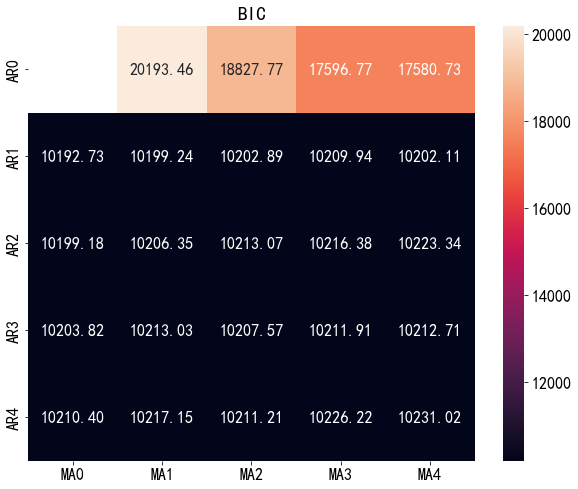

In [135]:
import itertools
ts_train = gold_df.dropna()
#当多组值都不符合时，遍历多组值，得出最好的值
p_min = 0
d_min = 0
q_min = 0
p_max = 4
d_max = 0
q_max = 4
 
# Initialize a DataFrame to store the results
results_bic = pd.DataFrame(index=['AR{}'.format(i) for i in range(p_min,p_max+1)],
                           columns=['MA{}'.format(i) for i in range(q_min,q_max+1)])
 
for p,d,q in itertools.product(range(p_min,p_max+1),
                               range(d_min,d_max+1),
                               range(q_min,q_max+1)):
    if p==0 and d==0 and q==0:
        results_bic.loc['AR{}'.format(p), 'MA{}'.format(q)] = np.nan
        continue
     
    try:
        model = sm.tsa.SARIMAX(ts_train, order=(p, d, q),
                               #enforce_stationarity=False,
                               #enforce_invertibility=False,
                              )
        results = model.fit()
        results_bic.loc['AR{}'.format(p), 'MA{}'.format(q)] = results.bic
    except:
        continue
results_bic = results_bic[results_bic.columns].astype(float)

fig, ax = plt.subplots(figsize=(10, 8))
ax = sns.heatmap(results_bic,
                 mask=results_bic.isnull(),
                 ax=ax,
                 annot=True,
                 fmt='.2f',
                 );
ax.set_title('BIC');
plt.savefig('./BIC_gold.eps',format='eps',dpi=150)

In [136]:
# 查看AIC与BIC结果是否一致
train_results = sm.tsa.arma_order_select_ic(ts_train, ic=['aic', 'bic'], trend='n', max_ar=4, max_ma=4)
 
print('AIC', train_results.aic_min_order)
print('BIC', train_results.bic_min_order)

C:\Users\27703\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\27703\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\27703\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\27703\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn

AIC (1, 4)
BIC (1, 0)


C:\Users\27703\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


### 预测函数

In [124]:
date_index = pd.date_range('2016-09-11','2021-09-10')
gold_df = gold_df.reindex(date_index)
gold_df = gold_df.fillna(method='bfill')
# df = gold_df['2017-01-01':'2017-05-15']
# def pred_by_history(df):
#     model = ARIMA(df[:-1], order=(1, 1, 0))         #只使用today之前的数据建立模型
#     result = model.fit()
#     # future = result.predict(df.index[-2],df.index[-1] ,dynamic=True, typ='levels')    #预测today的gold价格,起始数据必须在源数据中
#     future = result.forecast(1)
#     return future
# print(pred_by_history(df)[0])
# print(df[:-1])

print(gold_df)
print(gold_df[gold_df['USD (PM)'].isnull()])
gold_df.to_csv('./all_value.csv',index='True')

            USD (PM)
2016-09-11   1327.50
2016-09-12   1327.50
2016-09-13   1328.50
2016-09-14   1323.20
2016-09-15   1320.10
...              ...
2021-09-06   1823.85
2021-09-07   1810.75
2021-09-08   1797.95
2021-09-09   1795.35
2021-09-10   1799.90

[1826 rows x 1 columns]
Empty DataFrame
Columns: [USD (PM)]
Index: []


In [121]:
# 根据历史预测today价格的函数
def pred_by_history(df):
    model = ARIMA(df[:-1], order=(1, 1, 0))         #只使用today之前的数据建立模型
    result = model.fit()
    # future = result.predict(df.index[-1],df.index[-1] ,dynamic=True, typ='levels')  #预测today的gold价格,起始数据必须在源数据中
    future = result.forecast(1)      #返回today的预测值
    return future

# today = pd.to_datetime('2016-09-13')
# get = pred_by_history(bitcoin_df[:today])
pred_all_gold = {}     #字典中存放所有的黄金预测价格
# history = '2017-05-01'
gold_df = gold_df.fillna(method='bfill')   #填充所有数据
for today in gold_df['2016-09-14':].index.to_list():
    pred_gold = pred_by_history(gold_df[:today])        #只使用today之前的数据，返回的是today的预测值
    pred_all_gold[today] = pred_gold[0]
    print(today)

2016-09-14 00:00:00
2016-09-15 00:00:00
2016-09-16 00:00:00
2016-09-17 00:00:00
2016-09-18 00:00:00
2016-09-19 00:00:00
2016-09-20 00:00:00
2016-09-21 00:00:00
2016-09-22 00:00:00
2016-09-23 00:00:00
2016-09-24 00:00:00


C:\Users\27703\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


2016-09-25 00:00:00
2016-09-26 00:00:00
2016-09-27 00:00:00
2016-09-28 00:00:00
2016-09-29 00:00:00
2016-09-30 00:00:00
2016-10-01 00:00:00
2016-10-02 00:00:00
2016-10-03 00:00:00
2016-10-04 00:00:00
2016-10-05 00:00:00
2016-10-06 00:00:00
2016-10-07 00:00:00
2016-10-08 00:00:00
2016-10-09 00:00:00
2016-10-10 00:00:00
2016-10-11 00:00:00
2016-10-12 00:00:00
2016-10-13 00:00:00
2016-10-14 00:00:00
2016-10-15 00:00:00
2016-10-16 00:00:00
2016-10-17 00:00:00
2016-10-18 00:00:00
2016-10-19 00:00:00
2016-10-20 00:00:00
2016-10-21 00:00:00
2016-10-22 00:00:00
2016-10-23 00:00:00
2016-10-24 00:00:00
2016-10-25 00:00:00
2016-10-26 00:00:00
2016-10-27 00:00:00
2016-10-28 00:00:00
2016-10-29 00:00:00
2016-10-30 00:00:00
2016-10-31 00:00:00
2016-11-01 00:00:00
2016-11-02 00:00:00
2016-11-03 00:00:00
2016-11-04 00:00:00
2016-11-05 00:00:00
2016-11-06 00:00:00
2016-11-07 00:00:00
2016-11-08 00:00:00
2016-11-09 00:00:00
2016-11-10 00:00:00
2016-11-11 00:00:00
2016-11-12 00:00:00
2016-11-13 00:00:00


In [122]:
pred_gold_df = pd.DataFrame.from_dict(pred_all_gold,columns=['pred_value'],orient='index')

pred_gold_df.to_csv(f'D:/{str(pred_gold_df.index[0])[:10]}to{str(pred_gold_df.index[-1])[:10]}.csv',index='True')
pred_all_gold 

{Timestamp('2016-09-14 00:00:00', freq='D'): 1328.4999981930441,
 Timestamp('2016-09-15 00:00:00', freq='D'): 1325.6694136552394,
 Timestamp('2016-09-16 00:00:00', freq='D'): 1319.2050380978928,
 Timestamp('2016-09-17 00:00:00', freq='D'): 1311.059004952965,
 Timestamp('2016-09-18 00:00:00', freq='D'): 1315.2818578681977,
 Timestamp('2016-09-19 00:00:00', freq='D'): 1315.05,
 Timestamp('2016-09-20 00:00:00', freq='D'): 1315.05,
 Timestamp('2016-09-21 00:00:00', freq='D'): 1315.5054862676598,
 Timestamp('2016-09-22 00:00:00', freq='D'): 1320.9214741133821,
 Timestamp('2016-09-23 00:00:00', freq='D'): 1340.8910776621067,
 Timestamp('2016-09-24 00:00:00', freq='D'): 1337.4424520615753,
 Timestamp('2016-09-25 00:00:00', freq='D'): 1336.474463968554,
 Timestamp('2016-09-26 00:00:00', freq='D'): 1336.3,
 Timestamp('2016-09-27 00:00:00', freq='D'): 1336.3,
 Timestamp('2016-09-28 00:00:00', freq='D'): 1335.6513359475452,
 Timestamp('2016-09-29 00:00:00', freq='D'): 1319.8667588275548,
 Timesta

### 预测值与实际值对比

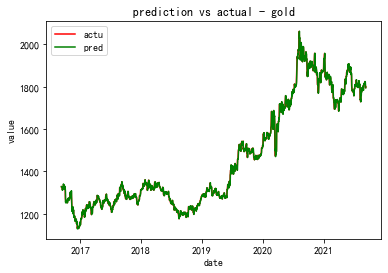

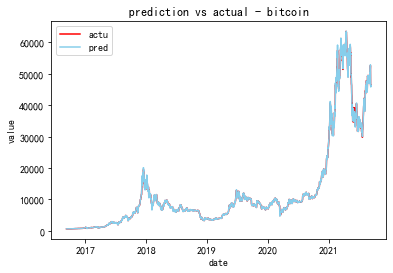

<Figure size 432x288 with 0 Axes>

In [206]:
all_value_df = pd.read_csv('./all_value.csv',index_col='date')
all_value_df.index = pd.to_datetime(all_value_df.index)


plt.plot(all_value_df['gold_value'],color="r",label="actu")    #实际
plt.plot(all_value_df['pred_value_gold'],color='g',label="pred")  #预测
plt.rcParams['font.sans-serif'] = ['SimHei']  # 显示汉字
 
plt.xlabel("date") #x轴命名表示
plt.ylabel("value") #y轴命名表示
plt.title("prediction vs actual - gold") 
plt.legend()#增加图例
plt.show() #显示图片
plt.savefig('./gold.eps',format='eps',dpi=150)

plt.plot(all_value_df['bitcoin_value'],color="r",label="actu")    #实际
plt.plot(all_value_df['pred_value_bitcoin'],color='skyblue',label="pred")  #预测
plt.rcParams['font.sans-serif'] = ['SimHei']  # 显示汉字
 
plt.xlabel("date") #x轴命名表示
plt.ylabel("value") #y轴命名表示
plt.title("prediction vs actual - bitcoin") 
plt.legend()#增加图例
plt.show() #显示图片
plt.savefig('./bitcoin.eps',format='eps',dpi=150)